# **CC Fraud Detection**

The datasets contain transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions

I have implemented K-Means SMOTE with ANN to classify the fraudulent transactions. Then, using confusion matrix, I estimate the f1-score and AUC using the ROC curve. 

In [1]:
#Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import MiniBatchKMeans as MiniKM
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [2]:
#load dataset
raw_data = pd.read_csv("../input/creditcardfraud/creditcard.csv") 
print(raw_data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
#sample, features - row * column
print(raw_data.shape)
#output- rows, columns

(284807, 31)


In [4]:
#Print the structure of the data
print(raw_data.apply(lambda x: [x.unique()]))

                                                Time  \
0  [0.0, 1.0, 2.0, 4.0, 7.0, 9.0, 10.0, 11.0, 12....   

                                                  V1  \
0  [-1.3598071336738, 1.1918571113148602, -1.3583...   

                                                  V2  \
0  [-0.0727811733098497, 0.26615071205963, -1.340...   

                                                  V3  \
0  [2.53634673796914, 0.16648011335321, 1.7732093...   

                                                  V4  \
0  [1.37815522427443, 0.448154078460911, 0.379779...   

                                                  V5  \
0  [-0.33832076994251803, 0.0600176492822243, -0....   

                                                  V6  \
0  [0.462387777762292, -0.0823608088155687, 1.800...   

                                                  V7  \
0  [0.239598554061257, -0.0788029833323113, 0.791...   

                                                  V8  \
0  [0.0986979012610507, 0.08510165491481

In [5]:
# using the dtypes() method to display the different datatypes available
print(raw_data.dtypes)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


In [6]:
X=raw_data.iloc[:,raw_data.columns!='Class']
Y=raw_data.iloc[:,raw_data.columns=='Class']
print(Y.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [7]:
X.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [8]:
X['normalizedAmount'] = StandardScaler().fit_transform(X['Amount'].values.reshape(-1,1))
X['normalizedTime']   = StandardScaler().fit_transform(X['Time'].values.reshape(-1,1))
X = X.drop(['Amount'],axis=1)
X = X.drop(['Time'],axis=1)

In [9]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,normalizedAmount,normalizedTime
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,-1.996541


In [10]:
X_train,X_test,Y_train,Y_test=\
train_test_split(X,Y,shuffle=True, test_size = 0.2,random_state=1234)

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(227845, 30)
(227845, 1)
(56962, 30)
(56962, 1)


In [12]:
print(Y_train.Class.value_counts())
print(Y_test.Class.value_counts())

0    227451
1       394
Name: Class, dtype: int64
0    56864
1       98
Name: Class, dtype: int64


In [13]:
print(Y_train.head())

        Class
268227      0
19255       0
52349       0
207139      0
146748      0


In [14]:
print(X_train.dtypes)

V1                  float64
V2                  float64
V3                  float64
V4                  float64
V5                  float64
V6                  float64
V7                  float64
V8                  float64
V9                  float64
V10                 float64
V11                 float64
V12                 float64
V13                 float64
V14                 float64
V15                 float64
V16                 float64
V17                 float64
V18                 float64
V19                 float64
V20                 float64
V21                 float64
V22                 float64
V23                 float64
V24                 float64
V25                 float64
V26                 float64
V27                 float64
V28                 float64
normalizedAmount    float64
normalizedTime      float64
dtype: object


# **Resampling with K-Means SMOTE**

As a starting point, we will initiate K-Means SMOTE algorithm with default values for following parameters:

Sampling Strategy = 0.333 (#minority instances / #majority instances)
K-neighbours = 5
random_state = 1234
Kmeans_estimator = MiniBatchKMeans(random_state = None)
cluster_balance_threshold = auto

For futher info about parameters, refer to this [link](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.KMeansSMOTE.html)

In [15]:
clf = MiniKM(n_clusters = 100, random_state = 1234)

[print('Class {} has {} instances'.format(label, count))
for label, count, in zip(*np.unique(Y_train, return_counts=True))]

kmeans_smote = KMeansSMOTE (sampling_strategy = 0.538,random_state = 1234,k_neighbors=10,
                            kmeans_estimator = clf,cluster_balance_threshold = "auto")

Y_train_reshape=np.ravel(Y_train)
X_KM, Y_KM = kmeans_smote.fit_resample(X_train,Y_train_reshape)

[print('Class {} has {} instances after resampling'.format(label, count))
for label, count, in zip(*np.unique(Y_KM, return_counts=True))]

Class 0 has 227451 instances
Class 1 has 394 instances
Class 0 has 227451 instances after resampling
Class 1 has 122368 instances after resampling


[None, None]

# **ANN with no resampling**

In [16]:
# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
# Adding the second hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the third hidden layer
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier.fit(X_train, Y_train, batch_size = 32, epochs = 10, validation_split = 0.2, verbose = 2, shuffle = True)

Epoch 1/10
5697/5697 - 7s - loss: 0.0146 - accuracy: 0.9982 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 2/10
5697/5697 - 7s - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 3/10
5697/5697 - 7s - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 4/10
5697/5697 - 7s - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 5/10
5697/5697 - 7s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 6/10
5697/5697 - 7s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 7/10
5697/5697 - 7s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 8/10
5697/5697 - 7s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 9/10
5697/5697 - 7s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9995
Epoch 10/10
5697/5697 - 7s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0026 - 

# **Predicting the test results**

In [17]:
Y_score = classifier.predict(X_test)
Y_pred = (Y_score > 0.5)

classifier.metrics_names
score = classifier.evaluate(X_test, Y_test)
score

# model performence with f1-score and accuracy
print(classification_report(Y_test, Y_pred))

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred) # rows = truth, cols = prediction
print(cm)

# f1_score
f1 = f1_score(Y_test, Y_pred)
print(f1)

# Accuracy_sccore
Acc = accuracy_score(Y_test, Y_pred)
print(Acc)

1781/1781 [==============================] - 1s 743us/step - loss: 0.0039 - accuracy: 0.9992
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.81      0.68      0.74        98

    accuracy                           1.00     56962
   macro avg       0.90      0.84      0.87     56962
weighted avg       1.00      1.00      1.00     56962

[[56848    16]
 [   31    67]]
0.7403314917127072
0.9991748885221726


# **ANN with K-Means SMOTE**

In [18]:
# Initialising the ANN
clf_KM = Sequential()
# Adding the input layer and the first hidden layer
clf_KM.add(Dense(units =15 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
# Adding the second hidden layer
clf_KM.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the second hidden layer
clf_KM.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
clf_KM.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
clf_KM.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
clf_KM.fit(X_KM, Y_KM, batch_size = 32, epochs = 10, verbose=2, validation_split=0.2)

Epoch 1/10
8746/8746 - 11s - loss: 0.0111 - accuracy: 0.9989 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 2/10
8746/8746 - 11s - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 3/10
8746/8746 - 10s - loss: 0.0033 - accuracy: 0.9995 - val_loss: 7.3776e-04 - val_accuracy: 1.0000
Epoch 4/10
8746/8746 - 11s - loss: 0.0031 - accuracy: 0.9996 - val_loss: 4.6343e-04 - val_accuracy: 1.0000
Epoch 5/10
8746/8746 - 10s - loss: 0.0030 - accuracy: 0.9996 - val_loss: 3.7602e-04 - val_accuracy: 1.0000
Epoch 6/10
8746/8746 - 10s - loss: 0.0029 - accuracy: 0.9995 - val_loss: 8.0454e-05 - val_accuracy: 1.0000
Epoch 7/10
8746/8746 - 11s - loss: 0.0028 - accuracy: 0.9996 - val_loss: 9.3889e-04 - val_accuracy: 1.0000
Epoch 8/10
8746/8746 - 11s - loss: 0.0026 - accuracy: 0.9996 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 9/10
8746/8746 - 11s - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 10/10
8746/8746 - 11s - loss: 0.0025 - accuracy

# **Predicting the test results**

In [19]:
Y_KM_score = clf_KM.predict(X_test)
Y_KM_pred = (Y_KM_score > 0.5)

clf_KM.metrics_names
score = clf_KM.evaluate(X_test, Y_test)
score

# model performence with f1-score and accuracy
print(classification_report(Y_test, Y_KM_pred))
cm_KM = confusion_matrix(Y_test, Y_KM_pred) # rows = truth, cols = prediction
print(cm_KM)

## Accuracy_sccore
Acc_KM = accuracy_score(Y_test, Y_KM_pred)
print(Acc_KM)

1781/1781 [==============================] - 2s 1ms/step - loss: 0.0035 - accuracy: 0.9993
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.78      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962

[[56847    17]
 [   22    76]]
0.9993153330290369


In [20]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)

print(fpr)
print(tpr)
print(thresholds)
print(roc_auc)

[0.00000000e+00 8.79290940e-05 8.79290940e-05 ... 9.98944851e-01
 9.98980023e-01 1.00000000e+00]
[0.         0.44897959 0.46938776 ... 1.         1.         1.        ]
[1.8559839e+00 8.5598385e-01 8.4723830e-01 ... 2.1643691e-23 2.1643197e-23
 0.0000000e+00]
0.9723022456731709


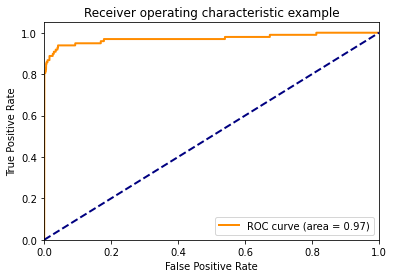

In [21]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()